In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../mats/2023-nwbc-data.csv')

In [3]:
df.shape

(736626, 95)

In [4]:
df['is_strike'] = 0
strike_events = ['called_strike', 'swinging_strike',
       'foul', 'blocked_ball', 'swinging_strike_blocked', 'hit_by_pitch',
       'foul_tip', 'foul_bunt', 'missed_bunt', 'bunt_foul_tip']
df.loc[df['description'].isin(strike_events), 'is_strike'] = 1

_df = df.loc[:, ['pitcher_name', 'pitch_name', 'is_strike']].groupby(['pitcher_name','pitch_name']).agg(n_pitches = ('is_strike','count')).reset_index()
df2 = df.merge(_df, on=['pitcher_name','pitch_name'])
df2 = df2.loc[df2['n_pitches']>=100]

df2['runs_scored'] = df2['post_bat_score'] - df2['bat_score']

In [5]:
df2.shape

(672545, 98)

In [6]:
df2.iloc[:,-2:].describe()

,n_pitches,runs_scored
count,672545.000000,672545.000000
mean,563.028991,0.028695
std,354.677992,0.209070
min,100.000000,0.000000
25%,290.000000,0.000000
50%,482.000000,0.000000
75%,754.000000,0.000000
max,1848.000000,4.000000


# Earned average run (ERA)

In [7]:
era=(df2
 .loc[:,['pitcher_name','pitcher','runs_scored']]
 .groupby(['pitcher_name','pitcher'],as_index=False)
 .sum())

#Important to know this takes filtered data and counts partial innings as full innings
_df = df2.loc[:,['pitcher','game_pk','inning']].drop_duplicates()
_df = (_df['pitcher']
       .value_counts()
       .to_frame().reset_index()
       .rename(columns={'index':'pitcher'
                        , 'pitcher':'n_innings'}))

era = era.merge(_df, on=['pitcher'])
era['era'] = (era['runs_scored']/era['n_innings'])*9
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era
0,"Abbott, Cory",676265,25,52,4.326923
1,"Abreu, Albert",656061,12,51,2.117647
2,"Abreu, Bryan",650556,26,81,2.888889
3,"Acevedo, Domingo",642758,32,82,3.512195
4,"Adam, Jason",592094,14,77,1.636364


# strike outs

In [8]:
strikeout_events = ['strikeout','strkeout_double_play']
df2['strikeout']=0
df2.loc[df2['events'].isin(strikeout_events), 'strikeout'] = 1
_df = (df2
       .loc[:, ['pitcher_name','pitcher','strikeout']]
       .groupby(['pitcher_name','pitcher'], as_index=False)
       .sum())
era = era.merge(_df, on=['pitcher_name','pitcher'])

In [9]:
#strike outs per 9 innings
era['k9'] = (era['strikeout']/era['n_innings'])*9

In [10]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000


# fielder-independent pitching (FIP)

In [11]:
df2['walk']= 0
df2.loc[df2['events']=='walk', 'walk']=1
df2['home_run']= 0
df2.loc[df2['events']=='home_run', 'home_run']=1
_df = (df2
        .loc[:, ['pitcher_name','pitcher','walk', 'home_run']]
        .groupby(['pitcher_name','pitcher'])
        .sum())
era = era.merge(_df, on=['pitcher_name','pitcher'])

In [12]:
era['fip'] = 3+(((era['home_run']*13) + (era['walk']*3) - (era['strikeout']*2)) / (era['n_innings']))

In [13]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571


# Data Visualization

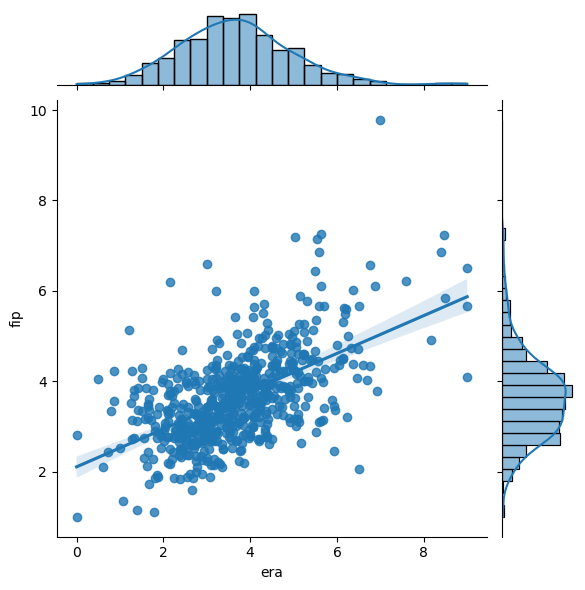

In [14]:
sns.jointplot(data=era, x='era', y='fip', kind='reg')
plt.show()

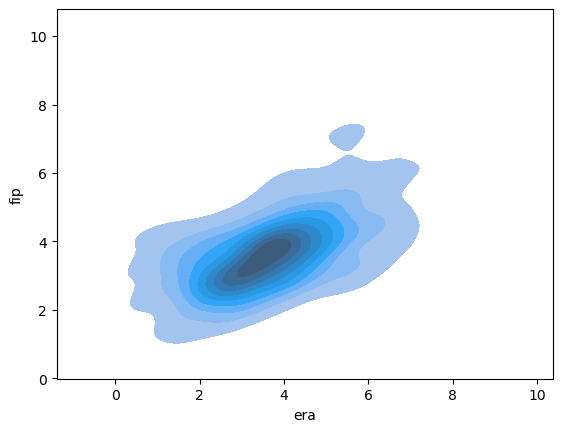

In [15]:
sns.kdeplot(data=era, x='era', y='fip',fill='True')
plt.show()

#  Stats

In [16]:
era[['fip','era','k9']].describe()

,fip,era,k9
count,632.000000,632.000000,632.000000
mean,3.651918,3.693438,6.801823
std,0.987219,1.345245,2.378781
min,1.000000,0.000000,0.000000
25%,2.987269,2.789156,5.400000
50%,3.584524,3.613715,6.947368
75%,4.137987,4.414468,8.417677
max,9.777778,9.000000,15.464789


In [17]:
era['era'].quantile(.01), era['era'].quantile(.999)

(0.8571428571428571, 9.0)

In [18]:
era.loc[:, ['fip','era','k9']].corr()

,fip,era,k9
fip,1.000000,0.569968,-0.423126
era,0.569968,1.000000,0.013280
k9,-0.423126,0.013280,1.000000


In [19]:
era.loc[:, ['fip','era','k9']].corr()**2

,fip,era,k9
fip,1.000000,0.324864,0.179035
era,0.324864,1.000000,0.000176
k9,0.179035,0.000176,1.000000


In [20]:
era['era_plus'] = (era['era'] / era['era'].mean())*100

In [21]:
era.head()

,pitcher_name,pitcher,runs_scored,n_innings,era,strikeout,k9,walk,home_run,fip,era_plus
0,"Abbott, Cory",676265,25,52,4.326923,45,7.788462,25,12,5.711538,117.151622
1,"Abreu, Albert",656061,12,51,2.117647,29,5.117647,11,1,2.764706,57.335382
2,"Abreu, Bryan",650556,26,81,2.888889,101,11.222222,30,2,1.938272,78.216787
3,"Acevedo, Domingo",642758,32,82,3.512195,58,6.365854,13,9,3.487805,95.092829
4,"Adam, Jason",592094,14,77,1.636364,77,9.000000,15,5,2.428571,44.304613


In [22]:
era['era_plus'].describe()

count    632.000000
mean     100.000000
std       36.422553
min        0.000000
25%       75.516510
50%       97.841486
75%      119.521900
max      243.675373
Name: era_plus, dtype: float64

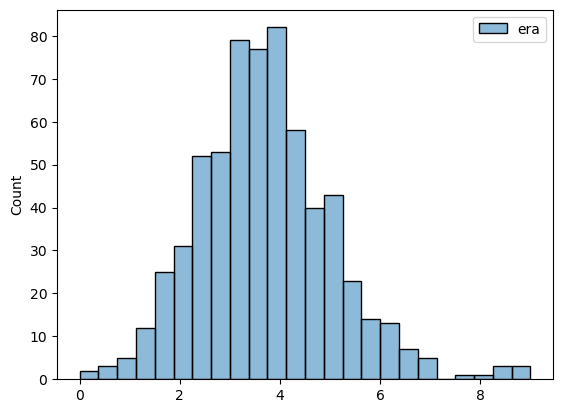

In [23]:
sns.histplot([era['era']])
plt.show()

In [24]:
#product moment correlation
r = pearsonr(era['era'], era['fip'])
r2 = r[0]**2
r[0], r2, r[-1]

(0.5699682005446798, 0.3248637496321403, 1.0072327941855903e-55)

In [25]:
#rank order correlation
#non normal distribution 30% explained variance
sr= spearmanr(era['era'],era['fip'])
sr2= sr[0]**2
sr[0], sr2, sr[-1]

(0.5511332247002545, 0.3037478313685012, 1.70116473641257e-51)

In [26]:
t= ttest_ind(era['era'],era['fip'])

t[0], t[-1]

(0.6255572955461834, 0.5317184612159784)

In [32]:
rmse= mean_squared_error(era['era'],era['fip'])**.5
rmse

1.1269891792175113

# visualization

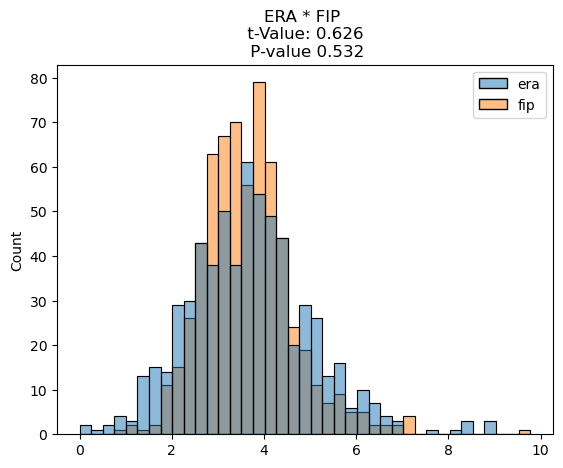

In [27]:
plt.title(f'ERA * FIP \n t-Value: {round(t[0],3)} \n P-value {round(t[-1],3)}')
sns.histplot(era[['era','fip']])
plt.show()

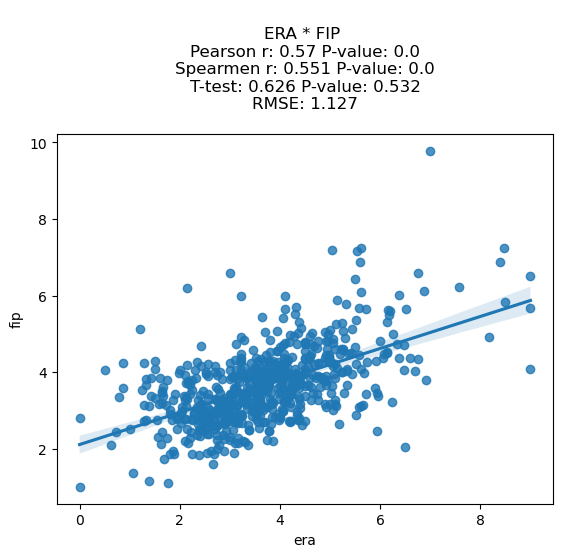

In [39]:
title= f"""
ERA * FIP 
Pearson r: {round(r[0],3)} P-value: {round(r[-1],3)}
Spearmen r: {round(sr[0],3)} P-value: {round(sr[-1],3)}
T-test: {round(t[0],3)} P-value: {round(t[1],3)}
RMSE: {round(rmse,3)}
"""

plt.title(title)
sns.regplot(data=era, x='era',y ='fip')
plt.show()